Exercise 2

**1. 
a&b.** The data set contains a totoal of *49707579* images split in to *340* classes. Each class contains an average of *140000* images. The biggest class is *snowman* with *340029* images and the smallest is *panda* with *113613* images.

**c.** 27 images from the first 9 classes can be seen here and later in the code.
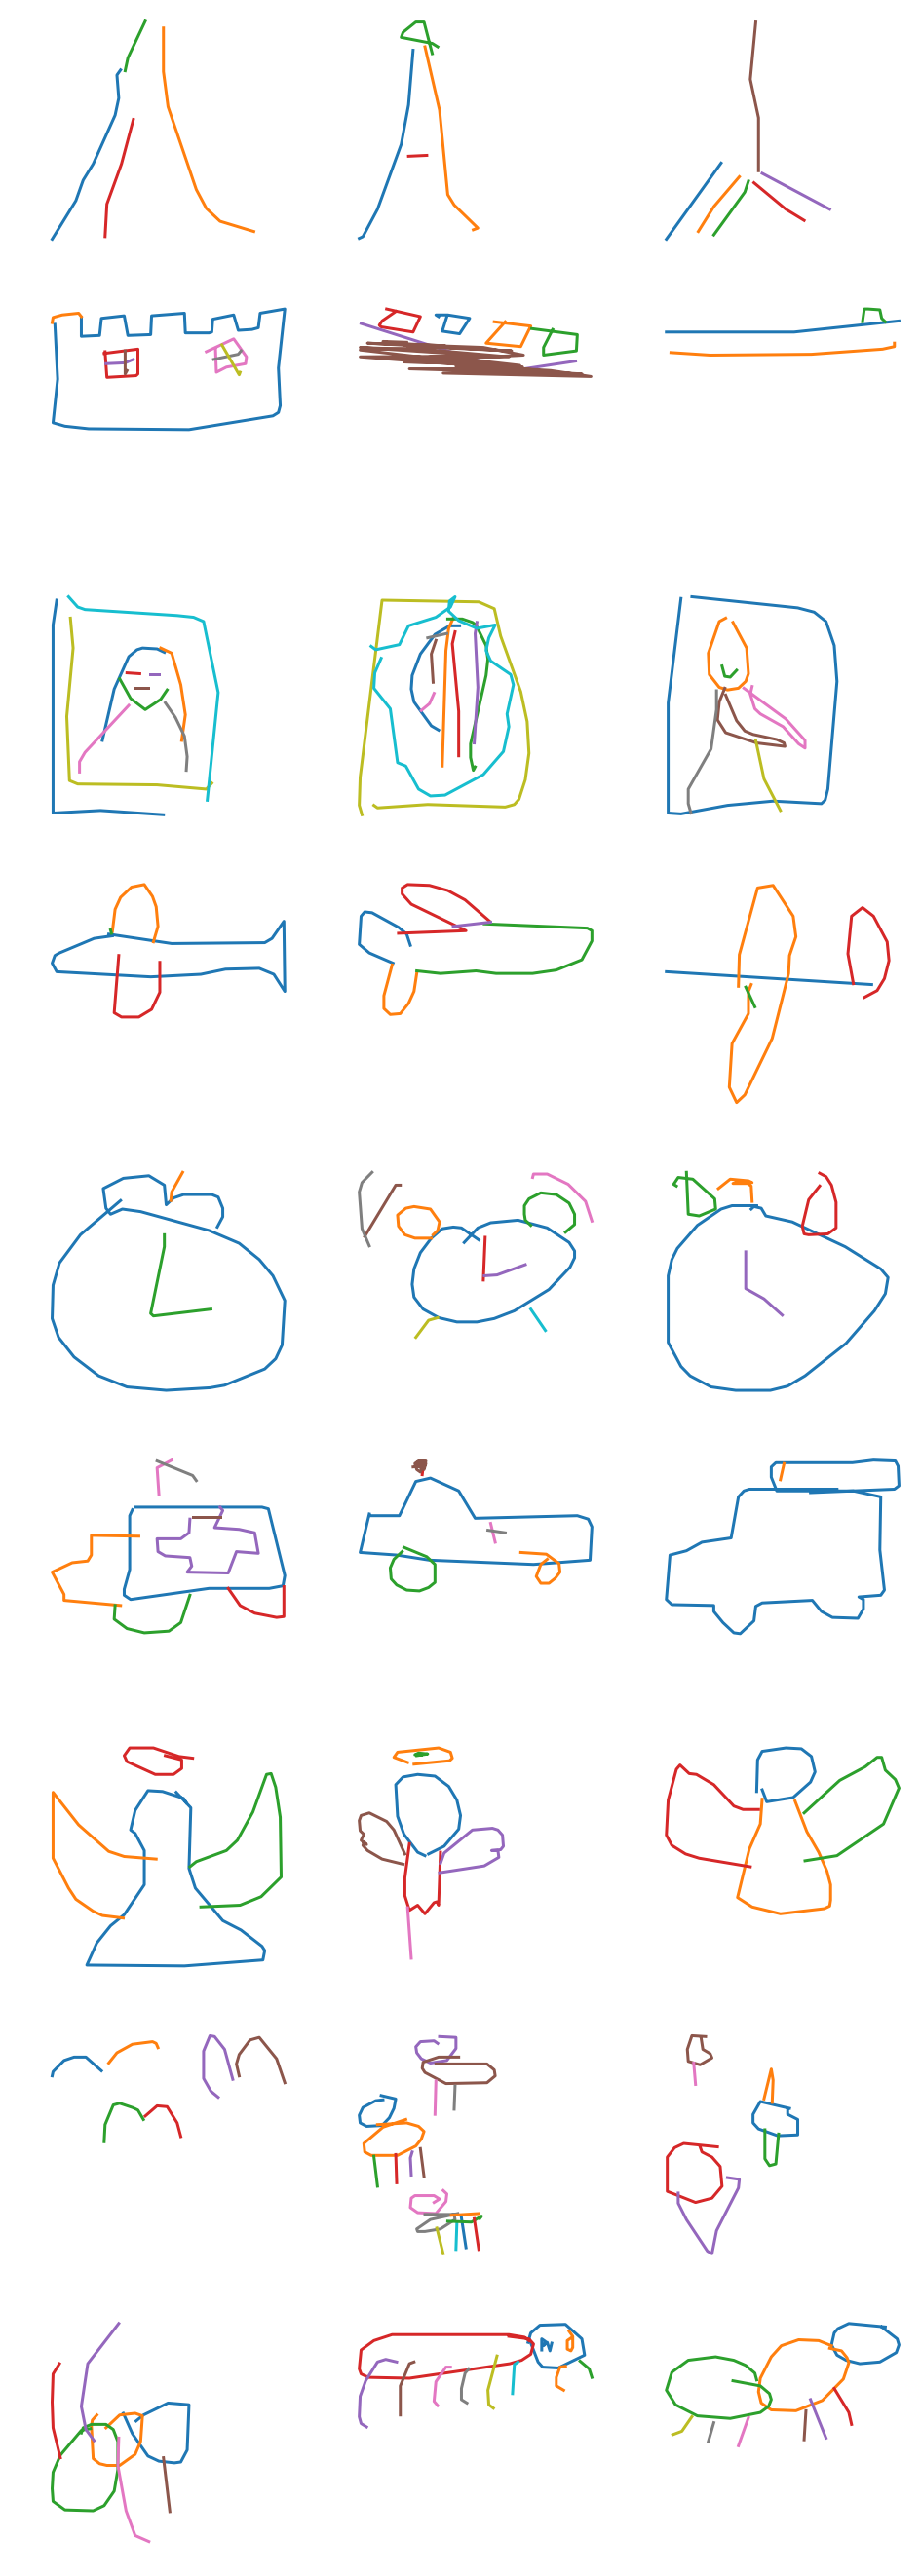

**d.** Based on the number of classes if the batch size is too small some classes might not be represented equaly in all batches, hurting the model's ability to generalise. Assuming that all samples are picked at random each class should be equaly represented. In this example a batch size of 512 is used, with 340 classes in total to chose from it is reasonable to assume that each batch contains atleast one image from each class. 
That aside, in general classifiers perform worse on classes with fewer samples. Usually, over-sampling (replicating samples) is used when there is not enough data, leaving the model vulnerable to overfitting. While the images per class vary in this data set  the amount of available data is big enough and the distribution of the data should not affect the training of the classifier.

**2.**  Three different networks were tested VGG16, ResNet50 and InceptionResNetV2. out of the three ResNet50 showed the best overall results therefore any further testing was done with that network.

**a.** For each test the network trained for 70 epochs with 30 steps each. Three different learning rates were tested with batch size of *512*: *0.03*, *0.003* and *0.001*

Learning rate of *0.03* proved to be too big and the network provided categorical accuracy around *0.3*
Learning rate of *0.003* and *0.001* have no significant difference in the accuracy, both performing around *0.6*

**b.** Also three different batch sizes were tested with learning rate of *0.003*: *256*, *512* and *1024*.

Batch size of *256* proved to be too small, reducing the categorical accuracy to *0.33*.
Batch size of *512* provided the best results, training acuracy of *0.61* and validation accuracy of *0.43*.
Batch size of *1024* provided results similar to batch size of *512* however it significantly increases the training time.

**c.** The *ResNet50* model used in the project is provided by Keras and can be used with pre-trained weights. The only change made directly to the model is to the inut layer which is changed to *64x64* instead of the default *224x224*. The model contains a number of Batch Normalization layers by default. 
As mentioned earlier two other models were also tested, however both performed significantly worse than ResNet50 and were quickly abandoned. 

**d.** Since each class contins around 130 000 samples data augmentation methods should not be necessary to observe good classification. However, by experimenting with Keras ImageDataGenerator to preprocess and augment the data  a slight increase in the overall accuracy was ovserved. From trial and error, experiments the most impact is observed from applying featurewise normalisation. by just using default values the  training acuracy was increased to *0.68* and validation accuracy to *0.5*.

**3.** 
**a.** In a number of experiments the easiest category to classify was *strawberry* and *pineapple*, however neither of those is among the classes with the most images. based on that it can be concluded that the distribution of the data has little to no effect on the results with the current batch size and training time. That could be explained by the fact that each iteration uses *512* of *49707579* images. At that rate less than 15% of the data was used during training. While throwing out good data is not optimal for training, it was necessary because of the time it takes to train the network. Going over 70 epochs of 30 steps takes about 6 hours.

**b.** While the overall data distribution might not have negative effect on the classification. The distribution of the data in regard to country of origin might have negative effect. Because *US* accounts for big portion of the samples (36%) and other countris provided only a few samples it is difficult to determine if the classification is because of poorly trained network or if there is a deeper corelation between classification and country of origin. 
For example, in the samples from *US*, 21 were corecctly classified and 2976 were incorrect. In the samples from *GB*,  4 were corecctly classified and 536 were incorrect.

**c.** The images bellow show five examples of good classification, *strawberry*, and five examples of bad classification, *jacket*. The test set contains 20 images of each class. The network correctly classified all 20 strawberries. On the other hand, the jacket samples among many other was missclassified every time. As mentioned earlier, the data distribution is not affecting the classification, and with that in mind the most likely explanation is that the network was not sufficiently trained. 
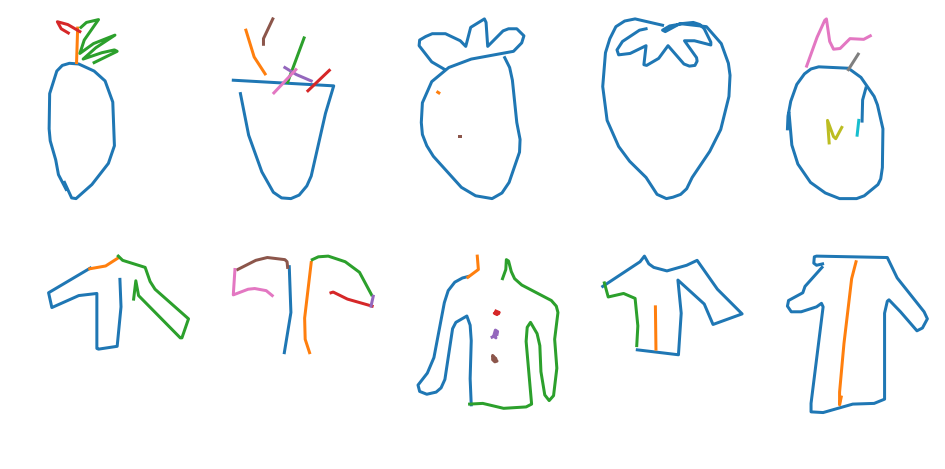

# Load Packages

In [ ]:
import numpy as np
import pandas as pd
import cv2
from glob import glob
import os
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
import random
import ast
import csv

In [ ]:
df = pd.read_csv('../input/test_simplified.csv')
#df = pd.read_csv('../input/train_simplified/airplane.csv')

#country_codes = set(df['countrycode'])
#df = df.sort_values(by='countrycode')
pd.set_option('display.max_columns', None)
print(df.head(5))



# Set Parameters

In [ ]:
IMG_SIZE = 64
IMG_BASE_SIZE = 256
BATCH_SIZE = 512
TRAIN_CSV_PATH_LIST = glob('../input/train_simplified/*.csv')
SKIP_RECORD = 0
RECORD_RANGE = 5000

In [ ]:
TRAIN_CSV_PATH_LIST[:5]

In [ ]:
len(TRAIN_CSV_PATH_LIST)

# Create One Hot Encoder

Generate a list of all the classes in the data set. And saves it as a categorical list. (340-dimensional vector that is all-zeros except for a 1 at the index corresponding to the class of the sample)

In [ ]:
class_list = []
for item in TRAIN_CSV_PATH_LIST:
    classname = os.path.basename(item).split('.')[0]
    class_list.append(classname)
    
item = pd.read_csv('../input/train_simplified/angel.csv')
print(item.head(10))

# Prints the number of images for each class
# Total number of images: 49707579
# Total number of classes: 340
total = 0
total_len = []
if True: # Set True to count number of images per class
    for i in class_list:
        item = pd.read_csv('../input/train_simplified/{}.csv'.format(i))
        print('Class: {}, Images: {}'.format(i, len(item)))
        total_len.append(len(item))
        total +=len(item)
    print('Total number of images {}'.format(total))
    total_len.sort()
    print(total_len[0])
    print(total_len[-1])

In [ ]:
class_list = sorted(class_list)
class_list[:5]

In [ ]:
#Number of classes
len(class_list)


In [ ]:
word_encoder = LabelEncoder()
word_encoder.fit(class_list)

In [ ]:
word_encoder.transform(class_list[:5])

In [ ]:
def my_one_hot_encoder(word):
    return to_categorical(word_encoder.transform([word]),num_classes=340).reshape(340)

In [ ]:
test_y = my_one_hot_encoder('The Eiffel Tower')

In [ ]:
test_y

In [ ]:
test_y.shape

# Create Train Data  Generator

The train data generator generates batches of images for the network to train on. The images for each batch are chosen at random from all classes.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
def train_generator(path_list, img_size, batch_size, lw=6):
    while True:
        csv_path_list = random.choices(path_list, k=batch_size)
        x = np.zeros((batch_size, img_size, img_size, 1))
        y = np.zeros((batch_size, 340))
        for j in range(batch_size):
            csv_path = csv_path_list[j]
            f = open(csv_path, 'r')
            reader = csv.reader(f)
            for _ in range(SKIP_RECORD+1):
                __ = next(reader)
            i = 0
            s = np.random.randint(RECORD_RANGE)
            for row in reader:
                if i == s:
                    drawing = row[1]
                    break
                else:
                    i += 1
            f.close()
            lst = ast.literal_eval(drawing)
            img = np.zeros((IMG_BASE_SIZE, IMG_BASE_SIZE), np.uint8)
            for t, stroke in enumerate(lst):
                color = 255 - min(t, 10) * 13
                for i in range(len(stroke[0]) - 1):
                    _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
            if img_size != IMG_BASE_SIZE:
                x[j, :, :, 0] = cv2.resize(img, (img_size, img_size))/255
            else:
                x[j, :, :, 0] = img/255
            classname = os.path.basename(csv_path).split('.')[0]
            y_tmp = my_one_hot_encoder(classname)
            y[j] = y_tmp
            
            data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)
            image_datagen = ImageDataGenerator(**data_gen_args)
            image_datagen.fit(x)
        yield x, y

In [ ]:
datagen = train_generator(path_list=TRAIN_CSV_PATH_LIST, img_size=IMG_SIZE, batch_size=BATCH_SIZE, lw=6)


In [ ]:
import matplotlib.pyplot as plt

if True: # Set True to Display images
    fig, axs = plt.subplots(nrows=9, ncols=3, sharex=True, sharey=True, figsize=(16, 48))
    drawings = []
    for i, instance in enumerate(class_list):
        if i>8:
            break
        item = pd.read_csv('../input/train_simplified/{}.csv'.format(instance))
        item = item[item.recognized]
        item['timestamp'] = pd.to_datetime(item.timestamp)
        item = item.sort_values(by='timestamp', ascending=False)[-3:]
        
        item['drawing'] = item['drawing'].apply(ast.literal_eval)
            
        for j, drawing in enumerate(item.drawing):
            ax = axs[i, j]
            
            for x, y in drawing:
                ax.plot(x, -np.array(y), lw=3)
            ax.axis('off')
    fig.savefig('items.png', dpi=200)
    plt.show();

In [ ]:
x, y = next(datagen)

In [ ]:
x.shape, y.shape, x.min(), x.max(), y.min(), y.max(), y.sum(), y[0].sum()

# Create Validation Set
contained classes of VAL_CLASS (choiced random)

In [ ]:
VAL_IMAGES_PER_CLASS = 20
VAL_CLASS = 340
VAL_SKIP_RECORD = SKIP_RECORD + RECORD_RANGE

In [ ]:
def create_val_set(path_list, val_class, val_images_per_class, img_size, lw=6):
    csv_path_list = random.sample(path_list, k=val_class)
    x = np.zeros((val_class*val_images_per_class, img_size, img_size, 1)) # Image
    y = np.zeros((val_class*val_images_per_class, 340)) # Class
    z = []
    for k in range(val_class):
        csv_path = csv_path_list[k]
        f = open(csv_path, 'r')
        reader = csv.reader(f)
        for _ in range(VAL_SKIP_RECORD+1):
            __ = next(reader)
        s = 0
        for row in reader:
            if s == val_images_per_class:
                break
            else:
                drawing = row[1]
                lst = ast.literal_eval(drawing)
                img = np.zeros((IMG_BASE_SIZE, IMG_BASE_SIZE), np.uint8)
                for t, stroke in enumerate(lst):
                    color = 255 - min(t, 10) * 13
                    for i in range(len(stroke[0]) - 1):
                        _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
                if img_size != IMG_BASE_SIZE:
                    x[k*val_images_per_class+s, :, :, 0] = cv2.resize(img, (img_size, img_size))/255
                else:
                    x[k*val_images_per_class+s, :, :, 0] = img/255
                classname = os.path.basename(csv_path).split('.')[0]
                y_tmp = my_one_hot_encoder(classname)
                y[k*val_images_per_class+s,:] = y_tmp
                z_tmp = (row[0], classname, lst)
                z.append(z_tmp)
                s += 1
        f.close()
    return x, y, z

In [ ]:
valid_x, valid_y, valid_z = create_val_set(path_list=TRAIN_CSV_PATH_LIST, val_class=VAL_CLASS,
                                  val_images_per_class=VAL_IMAGES_PER_CLASS, img_size=IMG_SIZE, lw=6)
print(valid_z[0])

In [ ]:
valid_x.shape, valid_y.shape, valid_x.min(), valid_x.max(), valid_y.min(), valid_y.max(), valid_y.sum(), valid_y[0].sum()

# Create Model

In [ ]:
from keras import Model
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.layers import Dropout
#from keras.applications import VGG16
from keras.applications import ResNet50
#from keras.applications import InceptionResNetV2
from keras import optimizers

def get_model(input_shape):
    #model = VGG16(input_shape=input_shape, include_top=True, weights=None, classes=340)
    model = ResNet50(input_shape=input_shape, include_top=True, weights=None, classes=340)
    #model = InceptionResNetV2(input_shape=input_shape, include_top=True, weights=None, classes=340)
    return model

In [ ]:
model = get_model(input_shape=(IMG_SIZE,IMG_SIZE,1))

In [ ]:
model.summary()

In [ ]:
# Values greater than lr=0.003 cause significant drop in performance.
c = optimizers.adam(lr = 0.003)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=c, metrics=['categorical_accuracy'])

# Training

In [ ]:
history = model.fit_generator(datagen, epochs=70, steps_per_epoch=30, verbose=1, validation_data=(valid_x, valid_y))

# Predict and Create Submission file

In [ ]:
test_df = pd.read_csv('../input/test_simplified.csv')

In [ ]:
test_df.shape

In [ ]:
test_df.head()

In [ ]:
def create_test_data(img_size, lw=6):
    x = np.zeros((test_df.shape[0], img_size, img_size, 1))
    for j in range(test_df.shape[0]):
        drawing = test_df.loc[j,'drawing']
        lst = ast.literal_eval(drawing)
        img = np.zeros((IMG_BASE_SIZE, IMG_BASE_SIZE), np.uint8)
        for t, stroke in enumerate(lst):
            color = 255 - min(t, 10) * 13
            for i in range(len(stroke[0]) - 1):
                _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
        if img_size != IMG_BASE_SIZE:
            x[j, :, :, 0] = cv2.resize(img, (img_size, img_size))/255
        else:
            x[j, :, :, 0] = img/255
    return x

In [ ]:
test_x = create_test_data(img_size=IMG_SIZE, lw=6)

In [ ]:
test_x.shape

In [ ]:
test_pred = model.predict(test_x, batch_size=128, verbose=1)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pred_rows = []
for i in range(test_df.shape[0]):
    test_top3 = test_pred[i].argsort()[::-1][:3]
    test_top3_words = word_encoder.inverse_transform(test_top3).tolist()
    test_top3_words = [k.replace(' ', '_') for k in test_top3_words]
    pred_words = test_top3_words[0] + ' ' + test_top3_words[1] + ' ' + test_top3_words[2]
    pred_rows += [{'key_id': test_df.loc[i, 'key_id'], 'word': pred_words}] 

In [ ]:
sub = pd.DataFrame(pred_rows)[['key_id', 'word']]
sub.to_csv('submission.csv', index=False)

In [ ]:
sub.head()

# Results

In [ ]:
mini_x, mini_y, mini_z = create_val_set(path_list=TRAIN_CSV_PATH_LIST, val_class=VAL_CLASS,
                                  val_images_per_class=VAL_IMAGES_PER_CLASS, img_size=IMG_SIZE, lw=6)

mini_pred = model.predict(valid_x)
pred_true = []
pred_false = []

for i in range(len(mini_z)):
    test_top3 = mini_pred[i].argsort()[::-1][:3]
    test_top3_words = word_encoder.inverse_transform(test_top3).tolist()
    #test_top3_words = [k.replace(' ', '_') for k in test_top3_words]

    if mini_z[i][1] in test_top3_words:
        pred_true.append((mini_z[i]))
    else:
        pred_false.append((mini_z[i]))
print('Correct Predictions {}'.format(len(pred_true)))
print('False Predictions {}'.format(len(pred_false)))
    

In [ ]:
from collections import Counter
tmp_country_c = []
tmp_class_c = []
tmp_draw_c = []
for i in pred_true:
    tmp_country_c.append(i[0])
    tmp_class_c.append(i[1])
    tmp_draw_c.append(i[2])
print(Counter(tmp_class_c))

tmp_country_w = []
tmp_class_w = []
tmp_draw_w = []
for i in pred_false:
    tmp_country_w.append(i[0])
    tmp_class_w.append(i[1])
    tmp_draw_w.append(i[2])
print(Counter(tmp_class_w))


In [ ]:
if True: # Set True to Display images
    fig, axs = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(16, 8))
    drawings = []
        
    for i, drawing in enumerate(tmp_draw_c):
        if i>4:
            break
        ax = axs[0, i]
        for x, y in drawing:
            ax.plot(x, -np.array(y), lw=3)
        ax.axis('off')
        
    for i, drawing in enumerate(tmp_draw_w):
        if i>4:
            break
        ax = axs[1, i]
        for x, y in drawing:
            ax.plot(x, -np.array(y), lw=3)
        ax.axis('off')
    fig.savefig('items.png', dpi=200)
    plt.show();